In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from fastai import datasets
from pathlib import Path
import torch
import gzip
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import random
import operator
import os 

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
#export
mpl.rcParams['image.cmap'] = 'gray'

def get_mnist_data():
    return get_data('mnist')
    
def get_data(name):
    name2url = {'mnist': 'http://deeplearning.net/data/mnist/mnist.pkl'}
    name2fn = {'mnist': process_mnist}
    if name not in name2url or name not in name2fn:
        raise Exception('Unrecognized dataset')
        
    path = datasets.download_data(name2url[name], ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((xt, yt), (xv, yv), _) = pickle.load(f, encoding='latin-1')
    
    return name2fn[name](xt, yt, xv, yv)

def process_mnist(xt, yt, xv, yv):
    xt, yt, xv, yv = map(tensor, (xt, yt, xv, yv))
    xt, xv = xt.float(), xv.float()
    mean, std = xt.mean(), xt.std()
    xt, xv = normalize(xt, mean, std), normalize(xv, mean, std)
    return xt, yt, xv, yv
    
def show_image(imgs):
    img = random.choice(imgs)
    if len(img.shape) == 1:
        size = int(img.shape[0] ** 0.5)
        shape = (size, size)
    else:
        shape = img.shape
    plt.imshow(img.view(shape))

In [4]:
#export
def plot(data, label):
    plt.plot(list(range(1,len(data)+1)), data)
    plt.xlabel('epoch')
    plt.ylabel(label)
    plt.xticks(list(range(1,len(data)+1)))
    plt.show()

In [5]:
#export
def test(a, b, cmp, cname=None):
    assert cmp(a, b), f"{cname or cmp.__name__}: \n{a}\n{b}"

def near(a, b): 
    return torch.allclose(a, b, rtol=1e-3, atol=1e-5)

def test_near(a, b): 
    test(a, b, near)

def test_near_zero(a,tol=1e-3):
    assert a.abs() < tol, f"Near zero: {a}"
    
def test_eq(a, b):
    return test(a, b, operator.eq)

In [6]:
#export
def matmul_naive(a, b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k] * b[k,j]
    return c

def matmul_element(a, b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

def matmul_broadcast(a, b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)
    return c

def matmul_einsum(a, b): 
    return torch.einsum('ik,kj->ij', a, b)

def matmul_torch(a, b):
    return a@b

In [7]:
#export
def normalize(x, m=None, s=None):
    return (x - (m if m else x.mean())) / (s if s else x.std())

In [8]:
x_train, y_train, x_valid, y_valid = get_mnist_data()
type(x_train), type(y_train), type(x_valid), type(y_valid)

(torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)

In [9]:
m1, m2 = x_valid[:5], torch.randn(784, 10)
%time _ = matmul_naive(m1, m2)
%time _ = matmul_element(m1, m2)
%time _ = matmul_broadcast(m1, m2)
%time _ = matmul_einsum(m1, m2)
%time _ = matmul_torch(m1, m2) # literal sonic, thanks torch

CPU times: user 831 ms, sys: 2.72 ms, total: 834 ms
Wall time: 835 ms
CPU times: user 1.3 ms, sys: 68 µs, total: 1.36 ms
Wall time: 1.33 ms
CPU times: user 485 µs, sys: 188 µs, total: 673 µs
Wall time: 640 µs
CPU times: user 1.02 ms, sys: 436 µs, total: 1.46 ms
Wall time: 1.27 ms
CPU times: user 180 µs, sys: 79 µs, total: 259 µs
Wall time: 212 µs


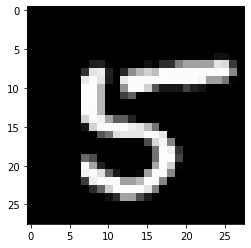

In [10]:
show_image(x_train) # rerun to reselect images

In [11]:
test_near_zero(x_train.mean())
test_near_zero(1 - x_train.std())

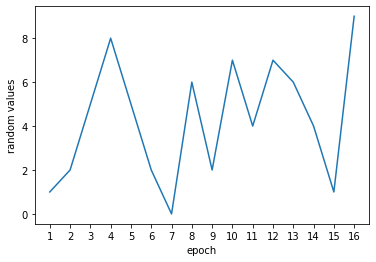

In [12]:
x = [1,2,5,8,5,2,0,6,2,7,4,7,6,4,1,9]
plot(x, 'random values')